In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import gc
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
trained_model_path = "./trained_models/ResNet.pth"

# Flags
load_existing_model = False

cuda


## Load the data into DataLoader
In this step, data is reshaped and normalized
- Normalization helps eliminate the effects of lighting (brightness, contrast, etc.) and other factors that may affect the image, leading to better training performance.


In [3]:

def data_loader(data_path, batch_size, random_seed=42, validation_size=0.1, test_size= 0.3, shuffle=True):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    dataset = datasets.ImageFolder(data_path, transform=transform)

    train_data, test_data = random_split(dataset, [1-test_size, test_size])

    # load the dataset
    training_dataset = train_data 
    validation_dataset = train_data

    num_train = len(training_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batch_size, sampler=train_sampler)

    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=batch_size, sampler=valid_sampler)

    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)
    
    return (training_loader, validation_loader, test_loader)

dataset_path = "./datasets/Colorectal Cancer"

training_loader, validation_loader, test_loader = data_loader(data_path=dataset_path, batch_size=64, test_size=0.3)

## Model Definition
This section contains the definitions for the ResNET model

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()

        # convolutional layers
        self.convolution_layer_1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.convolution_layer_2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))

        self.downsample = downsample
        
        # activation function
        self.relu = nn.ReLU()

        # numebr of output layers
        self.out_channels = out_channels

    def forward(self, x):
        residual = x

        output = self.convolution_layer_1(x)
        output = self.convolution_layer_2(output)

        if self.downsample:
            residual = self.downsample(x)

        output += residual
        output = self.relu(output)

        return output
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.convolutional_layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.max_pooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer0 = self._generate_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._generate_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._generate_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._generate_layer(block, 512, layers[3], stride = 2)

        self.average_pooling = nn.AvgPool2d(7, stride=1)

        self.fully_connected = nn.Linear(512, num_classes)

    def _generate_layer(self, block, planes, blocks, stride=1):
        downsample = None

        # downsample when the width/height of the output is smaller than the input or the stride is > 1
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.convolutional_layer_1(x)
        x = self.max_pooling(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x
    

num_epochs = 20
batch_size = 16
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

if load_existing_model:
    model.load_state_dict(torch.load(trained_model_path))

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)  

#Train the model
total_step = len(training_loader)

## Training the Model

Epoch [1/20], Loss: 3.6150
Accuracy of the network on the 4200 validation images: 68.33333333333333 %
Epoch [2/20], Loss: 0.9960
Accuracy of the network on the 4200 validation images: 84.28571428571429 %
Epoch [3/20], Loss: 1.9499
Accuracy of the network on the 4200 validation images: 89.04761904761905 %
Epoch [4/20], Loss: 0.1842
Accuracy of the network on the 4200 validation images: 90.0 %
Epoch [5/20], Loss: 1.1164
Accuracy of the network on the 4200 validation images: 87.38095238095238 %
Epoch [6/20], Loss: 1.2514
Accuracy of the network on the 4200 validation images: 77.61904761904762 %
Epoch [7/20], Loss: 0.1395
Accuracy of the network on the 4200 validation images: 87.38095238095238 %
Epoch [8/20], Loss: 0.5120
Accuracy of the network on the 4200 validation images: 85.0 %
Epoch [9/20], Loss: 0.9703
Accuracy of the network on the 4200 validation images: 92.85714285714286 %
Epoch [10/20], Loss: 0.6267
Accuracy of the network on the 4200 validation images: 92.38095238095238 %
Epoch

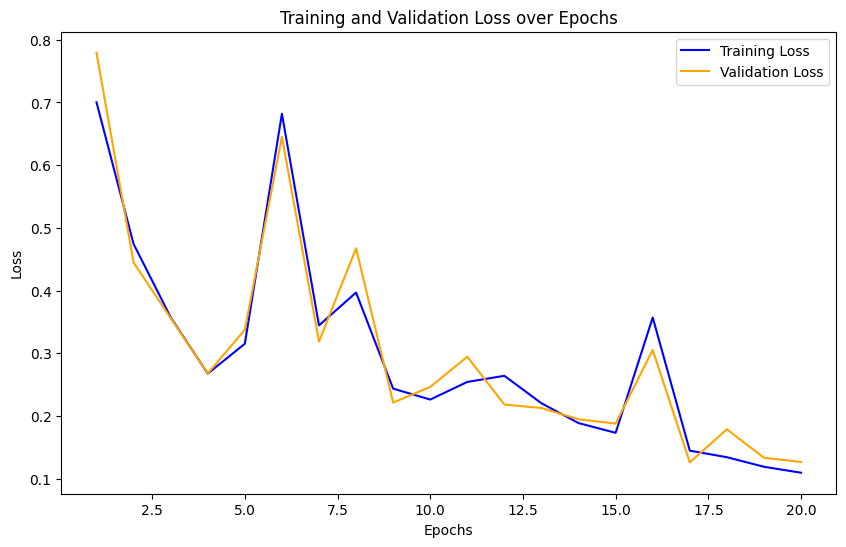

In [5]:
## Training the Model
total_step = len(training_loader)

train_validation_loss = []

if not load_existing_model:
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(training_loader):  
        # move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagate and update weights 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        # free up memory that is no longer in use 
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

      # Validation
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in validation_loader:
              # move tensors to device
              images = images.to(device)
              labels = labels.to(device)

              # get predictions
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)

              # update total and correct
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              # free up memory
              del images, labels, outputs

          print('Accuracy of the network on the {} validation images: {} %'.format(len(validation_loader.dataset), 100 * correct / total)) 
  
      # Calculate and store training loss
      train_loss = 0.0
      with torch.no_grad():
          for images, labels in training_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              train_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          train_loss /= len(training_loader)
          
      # Calculate and store validation loss  
      val_loss = 0.0
      with torch.no_grad():
          for images, labels in validation_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              val_loss += criterion(outputs, labels).item()
              del images, labels, outputs
          val_loss /= len(validation_loader)
          
      train_validation_loss.append({"train": train_loss, "validation": val_loss})

  # Plot training and validation loss
  plt.figure(figsize=(10, 6))
  epochs = range(1, len(train_validation_loss) + 1)
  train_losses = [x["train"] for x in train_validation_loss]
  val_losses = [x["validation"] for x in train_validation_loss]
  
  plt.plot(epochs, train_losses, color="blue", label='Training Loss')
  plt.plot(epochs, val_losses, color="orange", label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  torch.save(model.state_dict(), trained_model_path)  

## Test the model

In [6]:
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        # move tensors to device
        images = images.to(device)
        labels = labels.to(device)

        # get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # update total and correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # free up memory    
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), 100 * correct / total))   

Accuracy of the network on the 1800 test images: 95.83333333333333 %


## Feature Extraction of the trained encoder

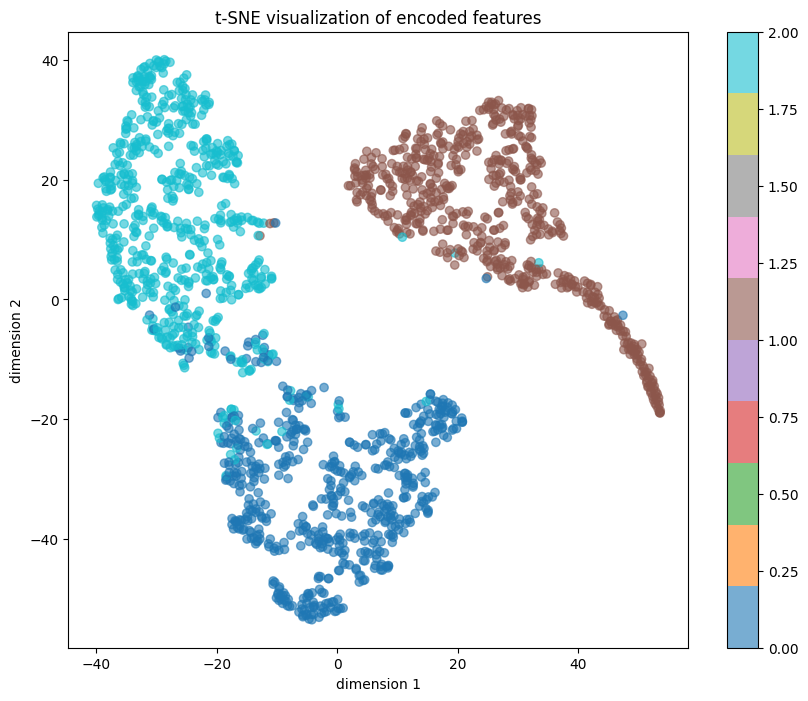

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

# Create feature extractor
feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

# Collect features and labels
features = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        batch_features = feature_extractor(images)
        features.append(batch_features.cpu().numpy())
        labels_list.append(labels.numpy())
        
        # Free up memory
        del images, batch_features
        torch.cuda.empty_cache()

# Concatenate all features and labels
features = np.concatenate(features)
labels_list = np.concatenate(labels_list)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], 
                     c=labels_list, cmap='tab10', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of encoded features')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.show()